## Part 4: Machine Learning

Link to [Part 1 - Data Wrangling](capstone1-wrangling.ipynb)
<br>
Link to [Part 2 - Exploratory Data Analysis (EDA)](capstone1-eda.ipynb)
<br>
Link to [Part 3 - Inferential Statistics](capstone1-is.ipynb)
<br>

Objective: Use supervised or unsupervised learning techniques to augment the data analysis

No data to train on to make predictions... so use clustering to uncover customer segments!

In [234]:
%%capture
%run capstone1-is.ipynb #Load Part 3

In [235]:
from sklearn.cluster import KMeans

In [236]:
new_amzn_df = amzn_data_RAW[['amazon-order-id', 'order-status', 'ship-postal-code', 'item-price']]
new_amzn_df = new_amzn_df[(new_amzn_df['order-status'] != 'Cancelled') & (new_amzn_df['item-price'].isna() == False)]
new_amzn_df = new_amzn_df.drop('order-status', axis=1)
new_amzn_df = new_amzn_df.rename(columns={'ship-postal-code' : 'zipcode'})
new_amzn_df['zipcode'] = new_amzn_df.apply(format_postal_codes, axis=1)
print(new_amzn_df.head())
print(new_amzn_df.shape)

       amazon-order-id zipcode  item-price
0  113-9235397-9394658   02118       74.99
1  112-1718234-0365053   98802       74.99
2  111-1795457-0212247   64506       74.99
3  114-9388024-7222668   94022       59.99
4  112-7199274-2267420   80231       59.99
(695, 3)


In [237]:
#Analyze 5 features: item-price, N1, avg_AGI, NUMDEP, and %_elderly (of ZIP Code assoc. w/ each order)
cluster_df = new_amzn_df.merge(joint_grouped.reset_index(), on='zipcode')
cluster_df = cluster_df[['amazon-order-id', 'item-price', 'N1', 'avg_AGI', 'avg_DEP', '%_elderly']]

print(cluster_df.head())

assert cluster_df.notna().all().all()
assert cluster_df.notnull().all().all()

       amazon-order-id  item-price     N1     avg_AGI   avg_DEP  %_elderly
0  113-9235397-9394658       74.99  13860  145.386364  1.055024  11.616162
1  111-2637313-8077817       54.74  13860  145.386364  1.055024  11.616162
2  113-9036596-9051448       49.95  13860  145.386364  1.055024  11.616162
3  112-1718234-0365053       74.99  14070   58.448685  1.231830  26.439232
4  111-1795457-0212247       74.99  10080   64.657242  1.051896  32.440476


In [238]:
cluster_matrix = cluster_df.values[:,1:]
print(cluster_matrix.shape)

(690, 5)


**Don't know optimal # of clusters in advance... so let's try different values.**

In [239]:
def getKMeansSS(arr, n_clusters):
    km = KMeans(n_clusters=n_clusters).fit(arr)
    return km.inertia_

In [240]:
SS_list = []
for n in range(2, 11):
    SS_list.append(getKMeansSS(cluster_matrix, n))
print(SS_list)

[19666026310.820583, 9111590124.576683, 5157463013.636709, 3793357456.183547, 2756816438.9500265, 1954058647.7178173, 1479964729.9508514, 1183439407.3277116, 947340828.7662314]


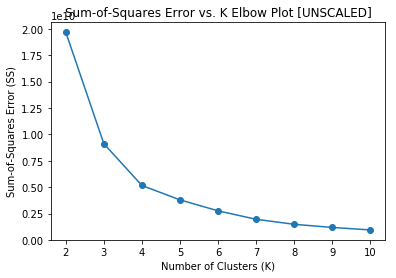

In [263]:
plt.plot(range(2,11), SS_list, '-o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum-of-Squares Error (SS)')
plt.title('Sum-of-Squares Error vs. K Elbow Plot [UNSCALED]')
plt.show() #K=4?

In [242]:
#Elbow plot looks pretty nice... Try again with scaling for comparison

from sklearn.preprocessing import StandardScaler

scaled_cm = StandardScaler().fit_transform(cluster_matrix)
print(scaled_cm)

[[ 1.066795   -0.13615142  0.70385606 -0.3547357  -1.33130622]
 [-0.09580724 -0.13615142  0.70385606 -0.3547357  -1.33130622]
 [-0.37081291 -0.13615142  0.70385606 -0.3547357  -1.33130622]
 ...
 [-0.09580724 -0.19279498 -0.6148846   0.04137853  0.55444536]
 [ 0.73667337 -0.12822132 -0.63897129 -3.8486517   6.87298564]
 [-0.09580724  1.60167308 -0.62696959  0.24161678 -0.61632387]]


In [243]:
SS_list2 = []
for n in range(2, 11):
    SS_list2.append(getKMeansSS(scaled_cm, n))
print(SS_list2)

[2700.7783260705314, 2345.0930085872033, 2057.4567919079054, 1817.6617762204692, 1604.6059826799808, 1457.9947101321814, 1306.957139169223, 1217.0115978065387, 1123.4781698690017]


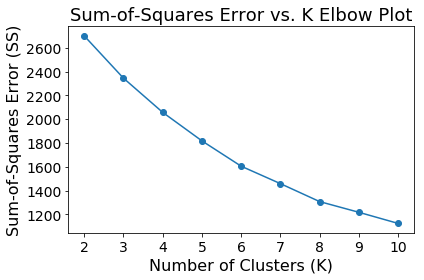

In [264]:
plt.plot(range(2,11), SS_list2, '-o')
plt.xlabel('Number of Clusters (K)', fontsize=16)
plt.ylabel('Sum-of-Squares Error (SS)', fontsize=16)
plt.title('Sum-of-Squares Error vs. K Elbow Plot', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.show() #No clear elbow point... K=5 for optimal value?
plt.tight_layout()
plt.savefig('plot_elbow.png', dpi=300)

**Despite the worse result for the elbow plot, given the differing scales of the data, the scaled matrix, scaled_cm, should and will be used for further ML analysis.**

In [245]:
#Try silhouette scores to determine K (# of clusters)
from sklearn.metrics import silhouette_score

In [265]:
silhouette_avgs = []
for n_clusters in range(2,11):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(scaled_cm)

    silhouette_avg = silhouette_score(scaled_cm, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    #silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
#Silhouette scoring finds weak cluster structures for every value of K between 2 and 10,
#and all scores are about the same (0.25-0.28).

('For n_clusters =', 2, 'The average silhouette_score is :', 0.21453100182652066)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.22995983661400518)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.24452422376823713)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.24676935934989846)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.24748318419871654)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.25648023163861333)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.22621628335472932)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.21674577996957817)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.22244981013789727)


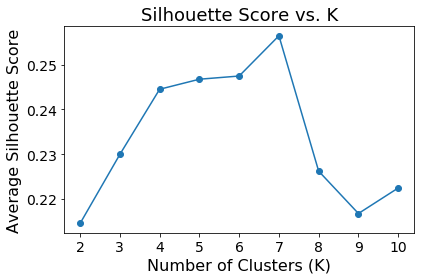

In [268]:
plt.plot(range(2,11), silhouette_avgs, '-o')
plt.xlabel('Number of Clusters (K)', fontsize=16)
plt.ylabel('Average Silhouette Score', fontsize=16)
plt.title('Silhouette Score vs. K', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.show()
plt.tight_layout()
plt.savefig('plot_silhouette.png', dpi=300)

In [247]:
#Perform PCA for visual plotting to attempt to manually identify clusters
from sklearn.decomposition import PCA

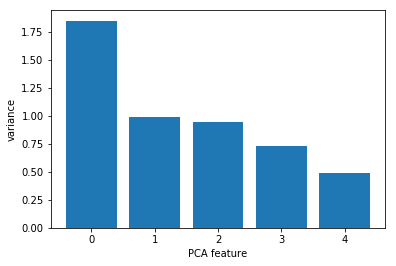

In [248]:
pca = PCA()
pca.fit(scaled_cm)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [249]:
print pd.DataFrame(pca.components_,columns=cluster_df.columns[1:],index = ['PC-0', 'PC-1', 'PC-2', 'PC-3', 'PC-4'])

      item-price        N1   avg_AGI   avg_DEP  %_elderly
PC-0   -0.122813 -0.437216  0.338705 -0.582806   0.582560
PC-1    0.964537  0.065634  0.238293 -0.089231   0.024785
PC-2   -0.233451  0.527997  0.788656 -0.083028  -0.194543
PC-3   -0.009091 -0.712226  0.427907  0.418876  -0.366183
PC-4    0.001582 -0.135968 -0.153012 -0.685583  -0.698622


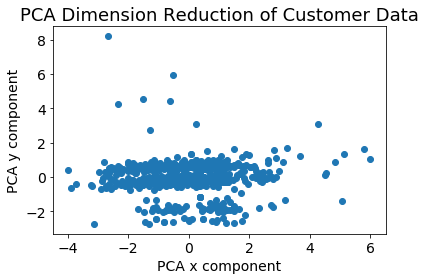

In [269]:
#Looks like 4 components making significant contributions... but let's reduce to 2 for ease of visualization
pca2 = PCA(n_components=2)
reduced_cm = pca2.fit_transform(scaled_cm)

df_pca = pd.DataFrame()
df_pca['Order_ID'] = cluster_df['amazon-order-id']
df_pca['pca_x'] = reduced_cm[:,0]
df_pca['pca_y'] = reduced_cm[:,1]

plt.scatter('pca_x', 'pca_y', data=df_pca)
plt.xlabel('PCA x component', fontsize=14)
plt.ylabel('PCA y component', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('PCA Dimension Reduction of Customer Data', fontsize=18)
#plt.show() #3 clusters?
plt.tight_layout()
plt.savefig('plot_pca.png', dpi=300)

In [251]:
#Try some alternate clustering algorithms...
from sklearn.cluster import AffinityPropagation, DBSCAN

In [252]:
# Affinity Propagation
aff_cluster = AffinityPropagation().fit(cluster_matrix)
print(len(aff_cluster.cluster_centers_[:,0])) #422 clusters for unscaled data?!

aff_cluster2 = AffinityPropagation().fit(scaled_cm)
print(len(aff_cluster2.cluster_centers_[:,0])) #50 clusters for scaled data?!

422
50


In [253]:
#Will we get better silhouette scores for higher number of clusters?
for n_clusters in range(11,21):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(scaled_cm)

    silhouette_avg = silhouette_score(scaled_cm, cluster_labels)
    #silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
#Nope.

('For n_clusters =', 11, 'The average silhouette_score is :', 0.22538136879834736)
('For n_clusters =', 12, 'The average silhouette_score is :', 0.20551925524298242)
('For n_clusters =', 13, 'The average silhouette_score is :', 0.21180742073761852)
('For n_clusters =', 14, 'The average silhouette_score is :', 0.20279091127008636)
('For n_clusters =', 15, 'The average silhouette_score is :', 0.20859751286416098)
('For n_clusters =', 16, 'The average silhouette_score is :', 0.2113023631140951)
('For n_clusters =', 17, 'The average silhouette_score is :', 0.2109313342419547)
('For n_clusters =', 18, 'The average silhouette_score is :', 0.20195547527984778)
('For n_clusters =', 19, 'The average silhouette_score is :', 0.2095532526887141)
('For n_clusters =', 20, 'The average silhouette_score is :', 0.21448420271214103)


Number of clusters found: 7


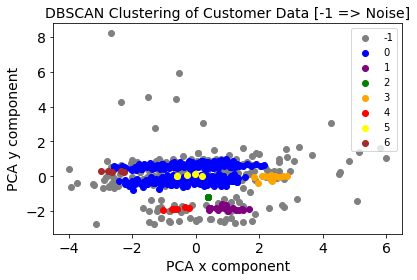

In [283]:
db_cluster_labels = DBSCAN(eps=0.66).fit_predict(scaled_cm) #Experimentation finds eps=0.66 to be optimal
#print(db_cluster_labels)
print('Number of clusters found: %d' % (len(set(db_cluster_labels)) - 1)) #cluster_label of -1 => "noisy" data point

df_pca['DBSCAN_Labels'] = db_cluster_labels
c_dict = {-1:'gray', 0:'blue', 1:'purple', 2:'green', 3:'orange', 4:'red', 5:'yellow', 6:'brown'}

fig, ax = plt.subplots()

for v in sorted(df_pca['DBSCAN_Labels'].unique()):
    df_pca_slice = df_pca[df_pca['DBSCAN_Labels'] == v]
    ax.scatter('pca_x', 'pca_y', c=c_dict[v], label=v, data=df_pca_slice)
    ax.legend(loc='upper right')

plt.xlabel('PCA x component', fontsize=14)
plt.ylabel('PCA y component', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('DBSCAN Clustering of Customer Data [-1 => Noise]', fontsize=14)
#plt.show()
plt.tight_layout()
plt.savefig('plot_dbscan.png', dpi=300)

In [285]:
#Inspect clusters for patterns

cluster6 = df_pca[df_pca['DBSCAN_Labels'] == 6]['Order_ID']
cluster6_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster6)]
print(cluster6_orders.describe()) #Very low AGI (30-45), very high item-price (specifically 69.24), very young pop., high N1

cluster3 = df_pca[df_pca['DBSCAN_Labels'] == 3]['Order_ID']
cluster3_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster3)]
print(cluster3_orders.describe()) #High AGI, high item-price, much older pop., low # DEP

cluster1 = df_pca[df_pca['DBSCAN_Labels'] == 1]['Order_ID']
cluster1_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster1)]
print(cluster1_orders.describe()) #Medium AGI, low item-price, average aged pop.

cluster4 = df_pca[df_pca['DBSCAN_Labels'] == 4]['Order_ID']
cluster4_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster4)]
print(cluster4_orders.describe()) #Medium-low AGI, very low item-price, very high N1, average aged pop.

cluster5 = df_pca[df_pca['DBSCAN_Labels'] == 5]['Order_ID']
cluster5_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster5)]
print(cluster5_orders.describe()) #VERY high AGI, medium-high item-price, very young pop.

cluster2 = df_pca[df_pca['DBSCAN_Labels'] == 2]['Order_ID']
cluster2_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster2)]
print(cluster2_orders.describe()) #5 orders all identical... low item-price, otherwise average

cluster0 = df_pca[df_pca['DBSCAN_Labels'] == 0]['Order_ID'] #Largest cluster
cluster0_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster0)]
print(cluster0_orders.describe()) #High AGI, medium-high item-price, average aged pop.

       item-price            N1    avg_AGI   avg_DEP  %_elderly
count        5.00      5.000000   5.000000  5.000000   5.000000
mean        69.24  16702.000000  39.743265  1.856214  13.958858
std          0.00   3597.439367   8.142574  0.043448   2.230721
min         69.24  13040.000000  29.522651  1.808157  11.647362
25%         69.24  14690.000000  33.117903  1.828758  12.281488
50%         69.24  15540.000000  41.783012  1.860294  14.166202
75%         69.24  17930.000000  45.906023  1.860947  14.340491
max         69.24  22310.000000  48.386733  1.922912  17.358747
       item-price            N1     avg_AGI    avg_DEP  %_elderly
count   13.000000     13.000000   13.000000  13.000000  13.000000
mean    51.346154   7367.692308   86.397118   0.817197  42.522538
std      8.186159   3439.154823   13.544702   0.057075   2.393486
min     24.990000   2070.000000   58.870088   0.700297  38.407080
25%     49.950000   5650.000000   77.332446   0.770642  41.282895
50%     54.740000   6080.000

In [256]:
#Since DBSCAN seems to have worked fairly well, let's try HDBSCAN, an upgraded version of DBSCAN
#(From the same authors as DBSCAN: https://github.com/scikit-learn-contrib/hdbscan)

import hdbscan

Number of clusters found: 8


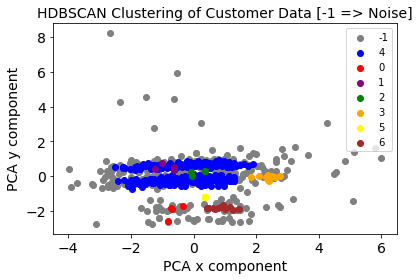

In [284]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4) #min_cluster_size=4 produces most visually reasonable clusters
hdb_cluster_labels = clusterer.fit_predict(scaled_cm)
print('Number of clusters found: %d' % len(set(hdb_cluster_labels)))

df_pca['HDBSCAN_Labels'] = hdb_cluster_labels
c_dict = {-1:'gray', 0:'red', 1:'purple', 2:'green', 3:'orange', 4:'blue', 5:'yellow', 6:'brown', 7:'black'}

fig, ax = plt.subplots()

df_pca_noise = df_pca[df_pca['HDBSCAN_Labels'] == -1]
ax.scatter('pca_x', 'pca_y', c='gray', label=-1, data=df_pca_noise)
ax.legend()

df_pca_bulk = df_pca[df_pca['HDBSCAN_Labels'] == 4]
ax.scatter('pca_x', 'pca_y', c='blue', label=4, data=df_pca_bulk)
ax.legend()

df_pca_remainder = df_pca[~df_pca.isin(df_pca_noise.append(df_pca_bulk))].dropna()
#print(df_pca_remainder)
for v in sorted(df_pca_remainder['HDBSCAN_Labels'].unique().astype(int)):
    df_pca_slice = df_pca_remainder[df_pca_remainder['HDBSCAN_Labels'] == v]
    ax.scatter('pca_x', 'pca_y', c=c_dict[v], label=v, data=df_pca_slice)
    ax.legend(loc='upper right')

#plt.scatter('pca_x', 'pca_y', c='DBSCAN_Labels', data=df_pca)
plt.xlabel('PCA x component', fontsize=14)
plt.ylabel('PCA y component', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('HDBSCAN Clustering of Customer Data [-1 => Noise]', fontsize=14)
#plt.show()
plt.tight_layout()
plt.savefig('plot_hdbscan.png', dpi=300)
#Very similar to DBSCAN result. Drops DBSCAN's cluster '6' and in place of DBSCAN cluster '5', finds clusters '1' and '2'

In [258]:
#Inspect HBDSCAN clusters 1 & 2

cluster1h = df_pca[df_pca['HDBSCAN_Labels'] == 1]['Order_ID']
cluster1h_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster1h)]
print(cluster1h_orders.describe()) #Medium AGI, high item-price, medium-high # DEP, younger pop., very low N1

cluster2h = df_pca[df_pca['HDBSCAN_Labels'] == 2]['Order_ID']
cluster2h_orders = cluster_df[cluster_df['amazon-order-id'].isin(cluster2h)]
print(cluster2h_orders.describe()) #Very high AGI, high item-price, very low # DEP, young pop., high N1

       item-price          N1    avg_AGI   avg_DEP  %_elderly
count      4.0000     4.00000   4.000000  4.000000   4.000000
mean      70.6775  5387.50000  67.830536  1.466006  16.752040
std        2.8750  1359.51891  17.845556  0.042142   3.653908
min       69.2400  3620.00000  50.417680  1.405797  12.569316
25%       69.2400  4962.50000  60.062784  1.452564  14.814959
50%       69.2400  5500.00000  64.061539  1.480345  16.584062
75%       70.6775  5925.00000  71.829291  1.493787  18.521143
max       74.9900  6930.00000  92.781385  1.497537  21.270718
       item-price            N1     avg_AGI   avg_DEP  %_elderly
count    5.000000      5.000000    5.000000  5.000000   5.000000
mean    53.782000  20776.000000  163.123546  0.787204  12.009650
std      2.142153   3237.040315    7.695682  0.033510   0.419946
min     49.950000  17230.000000  157.503414  0.750495  11.549623
25%     54.740000  17230.000000  157.503414  0.750495  11.549623
50%     54.740000  23140.000000  157.503414  0.81167

**Conclusion:**

Initially, our customers did not seem to be clustered along the metrics I have chosen to analyze (price of items purchased, number of filings [proxy for ZIP code size], average AGI, average number of dependents, and average % elderly population). However, after experimenting with other clustering algorithms, I found that DBSCAN suggests several clusters (along with many noisy points). Manual inspection of these smaller clusters reveals similarities between the orders therein, suggesting that the clusterings are indeed legitimate. Most of the clusters are very small though (5-28 customers), except for the largest cluster, whose features are fairly broad and generic, essentially representing the average of our customer base. More samples would hopefully enlarge these smaller clusters (thus increasing confidence in their legitimacy).

As noted, HDBSCAN produces a similar result to DBSCAN. While it should be all-around superior to DBSCAN (according to the creators, anyway), its superiority in this application is questionable. It disregards one very distinct cluster found by DBSCAN, and essentially splits another DBSCAN cluster into two very small, but reasonably distinct clusters.

Overall, it makes some sense that DBSCAN (and HDBSCAN) would perform better than the other clustering algorithms. For one thing, it is the only algorithm that attempts to deal with "noise", separating those points from the "meaningful" data in this 5-dimensional feature space. It is also very good at capturing non-linearly separable clusters (unlike many other algorithms which can only find globular clusters). The DBSCAN parameter eps requires some experimentation to tune, but it seems that if reasonable clusters can be found at all, varying eps will inevitably produce a gradient of results from nonsensical to reasonable, from which an optimal value (or values) can be chosen.